In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [9]:
import os
print(os.listdir('/content/'))

['.config', 'drive', 'sample_data']


In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            '/content/drive/MyDrive/potato_di', # Updated path to the extracted folder
            shuffle=True,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE
        )

Found 2222 files belonging to 3 classes.


In [11]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(dataset)

70

In [13]:
68*32

2176

In [14]:
for image_batch,label_batch in dataset.take(1):

  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1]


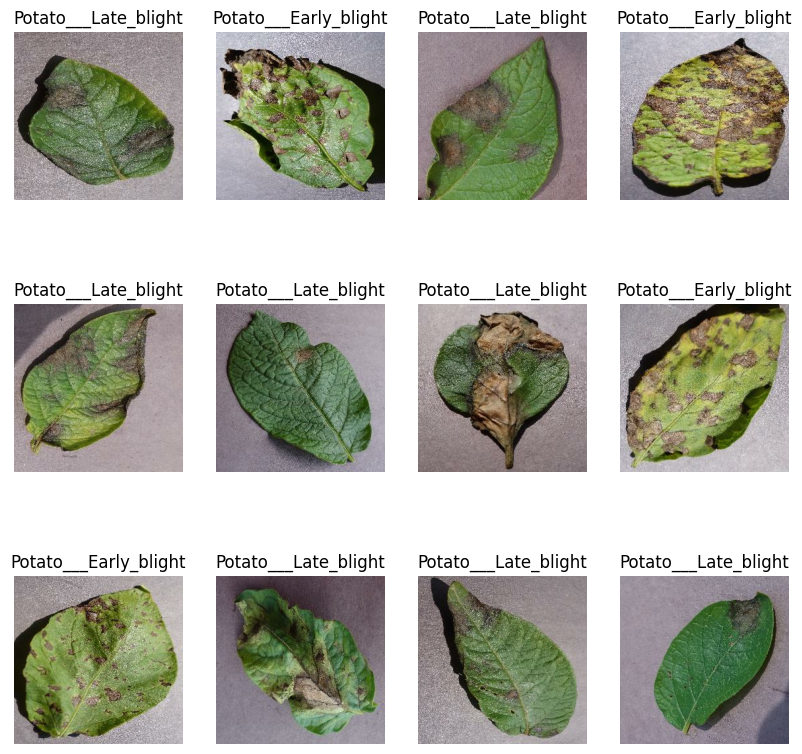

In [15]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')


In [16]:
train_size=0.8
len(dataset)*train_size


56.0

In [17]:
train_dataset=dataset.take(54)
len(train_dataset)

54

In [18]:
test_ds=dataset.skip(54)
len(test_ds)

16

In [19]:
val_size=0.1
len(dataset)*val_size

7.0

In [20]:
test_ds.take(6)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds=test_ds.skip(6)
len(test_ds)

10

In [23]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split * ds_size)
  val_size=int(val_split * ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [24]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

56

In [26]:
len(val_ds)

7

In [27]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Use tf.keras.layers.Resizing
    tf.keras.layers.Rescaling(1. / 255)  # Use tf.keras.layers.Rescaling
])

In [29]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Changed to tf.keras.layers.RandomFlip
    tf.keras.layers.RandomRotation(0.2)  # Changed to tf.keras.layers.RandomRotation
])

In [30]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.5417 - loss: 0.8898 - val_accuracy: 0.8170 - val_loss: 0.5445
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8426 - loss: 0.4299 - val_accuracy: 0.9062 - val_loss: 0.2333
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.9193 - loss: 0.2253 - val_accuracy: 0.9062 - val_loss: 0.2066
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.8876 - loss: 0.2526 - val_accuracy: 0.8393 - val_loss: 0.4884
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.9485 - loss: 0.1395 - val_accuracy: 0.8571 - val_loss: 0.3256
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9229 - loss: 0.1942 - val_accuracy: 0.8527 - val_loss: 0.3544
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9570 - loss: 0.1168 - val_accuracy: 0.9062 - val_loss: 0.2266
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9772 - loss: 0.0755 - val_accuracy: 0.9062 - v

In [34]:
scores=model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - accuracy: 0.8729 - loss: 0.3553


In [35]:
scores

[0.3051745593547821, 0.8883928656578064]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 56}

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
history.history['accuracy']

[0.6389508843421936,
 0.8470982313156128,
 0.9313616156578064,
 0.9168526530265808,
 0.9481026530265808,
 0.9352678656578064,
 0.9587053656578064,
 0.9732142686843872,
 0.9732142686843872,
 0.9369419813156128,
 0.94140625,
 0.9709821343421936,
 0.97265625,
 0.9715401530265808,
 0.9754464030265808]

In [40]:
c

NameError: name 'c' is not defined

In [41]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

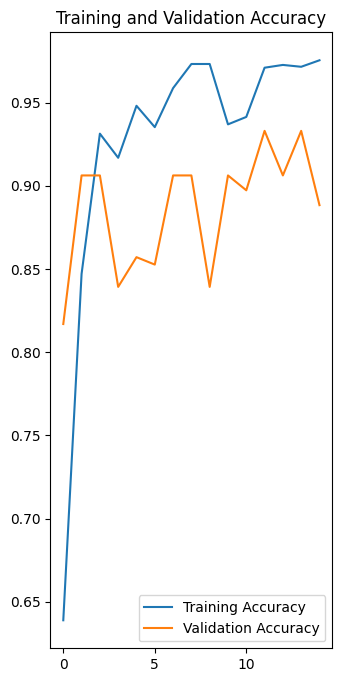

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)),acc,label='Training Accuracy') # Changed range(EPOCHS) to range(len(acc))
plt.plot(range(len(val_acc)),val_acc,label='Validation Accuracy') # Changed range(EPOCHS) to range(len(val_acc))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___healthy


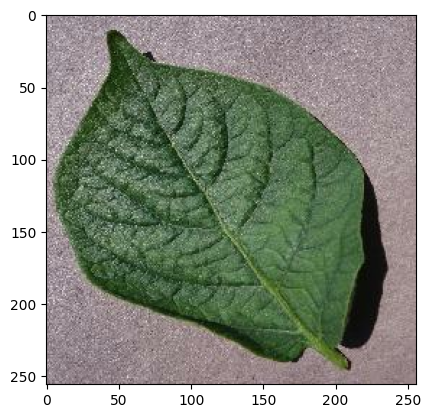

In [43]:
import numpy as np # Import the numpy library and assign it the alias 'np'

for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])
  batch_prediction=model.predict(images_batch)
  print('predicted label:',class_names[np.argmax(batch_prediction[0])]) # Now np is recognized

In [44]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


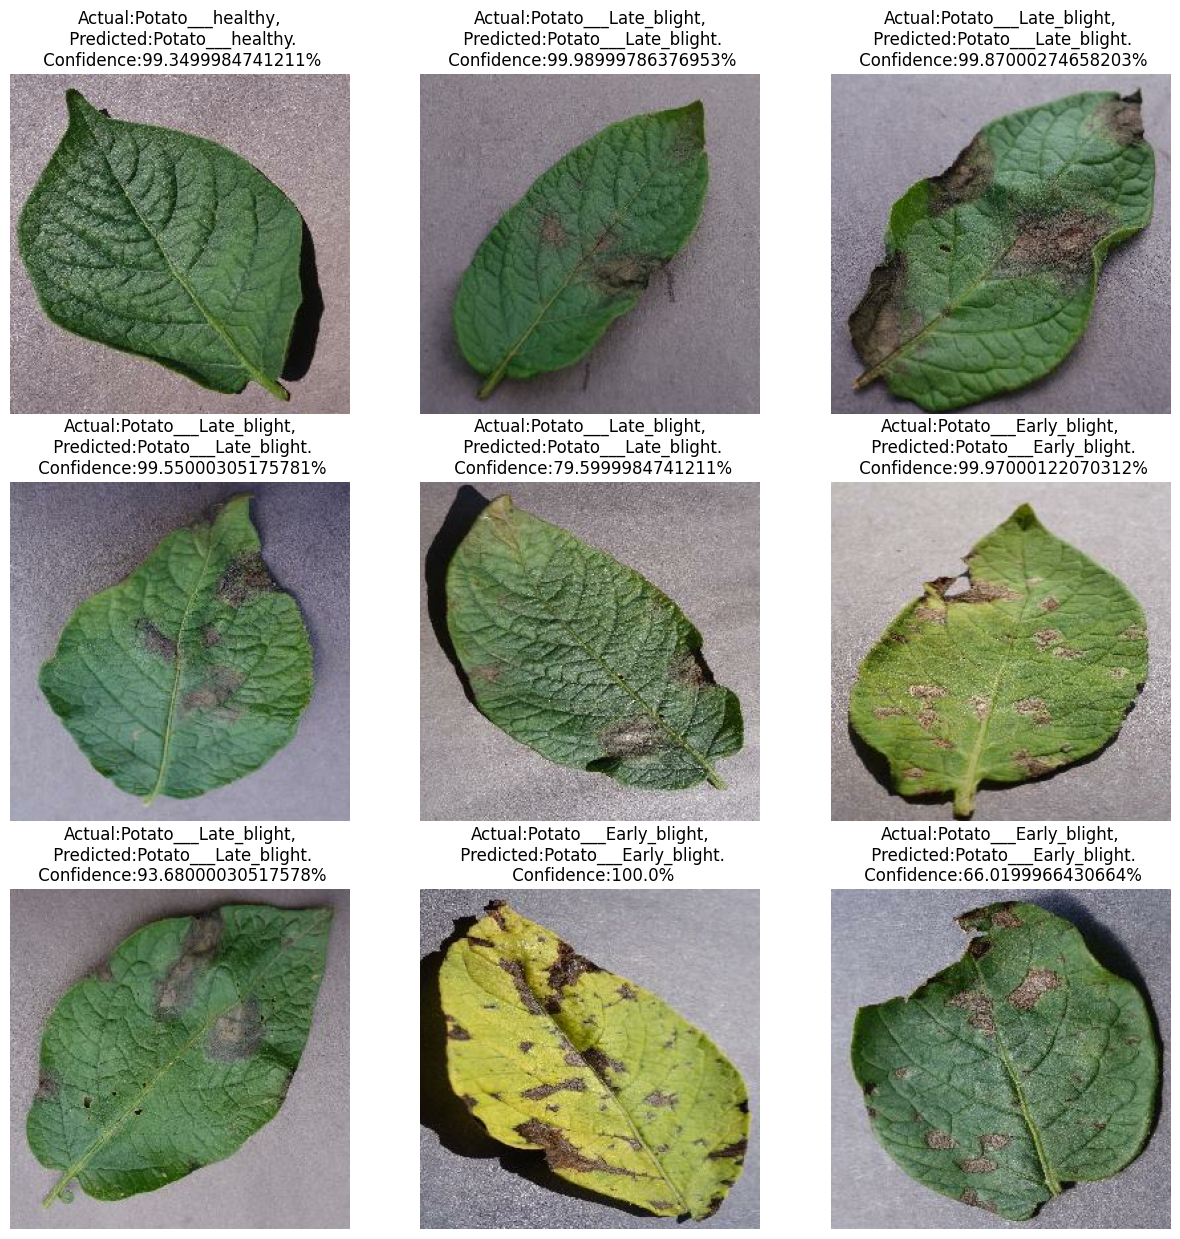

In [45]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    actual_label=class_names[labels[i].numpy()]
    predicted_label,confidence=predict(model,images)
    plt.title(f"Actual:{actual_label},\n Predicted:{predicted_label}.\n Confidence:{confidence}%")
    plt.axis('off')

In [46]:
model_version=1
model.save(f'/content/model{model_version}.keras') # Added '.keras' extension

In [47]:
import os
model_version

1

In [48]:
model.save("potato_disease_model.h5")


In [ ]:
model.save("potato_disease_model.h5")
print("Model saved as potato_disease_model.h5")

In [ ]:
model.save("potato_disease_model.keras")
print("Model saved as potato_disease_model.h5")